In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from generate_data import generate_Ls, generate_sylvester_data
from proximal_gradient_descent import (
    get_optimizer_oracles,
    proximal_accelerated_gradient,
    project_to_lower_with_positive_diag,
    warm_start
)
from plotting_utilities import get_metrics, patternify_Ls, one_example_prs
from sklearn.metrics import precision_score, recall_score, matthews_corrcoef, auc
import pickle

# Prevent Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [150]:
np.random.seed(0)
dims = (3, 3)
sparsity = 0.1
true_Ls = [
    np.array([[1, 0, 0], [0, 1, 0], [0.2, 0.5, 1]]),
    np.array([[1, 0, 0], [0, 1, 0], [0.2, 0.5, 1]])
]
X = generate_sylvester_data(true_Ls, normalize=True, source_distribution=np.random.normal)

orderings = {
    "abc": [0, 1, 2],
    "acb": [0, 2, 1],
    "bac": [1, 0, 2],
    "bca": [1, 2, 0],
    "cab": [2, 0, 1],
    "cba": [2, 1, 0]
}

all_patterns = dict()

for name, ordering in orderings.items():
    inverse_ordering = np.argsort(ordering)

    # Re-order the features in X according to the specified ordering
    _X = X[:, ordering].copy()


    patterns_1 = []
    patterns_2 = []

    L_init = [np.eye(d) for d in dims]

    frobreg = 1/np.prod(dims)**(1/len(dims))
    glassoregs = np.logspace(-2, 0.5, 100)

    for glassoreg in glassoregs:
        objective, gradient, proximal = get_optimizer_oracles(_X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, (_, eps, _, _) = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=L_init,
            mu=0.2,
            init_alpha=1,
            tau=0.5,
            beta=0.0001,
            max_iter=100,
            tol=1e-5
        )

        # Recover the original features axis
        Ls[1] = Ls[1][inverse_ordering][:, inverse_ordering]

        patterns_1.append(Ls[0][np.tril_indices_from(Ls[0], k=-1)])
        patterns_2.append(Ls[1][np.tril_indices_from(Ls[1], k=-1)])

    all_values = {
        "a--b on axis 1": [p[0] for p in patterns_1],
        "a--c on axis 1": [p[1] for p in patterns_1],
        "b--c on axis 1": [p[2] for p in patterns_1],
        "a--b on axis 2": [p[0] for p in patterns_2],
        "a--c on axis 2": [p[1] for p in patterns_2],
        "b--c on axis 2": [p[2] for p in patterns_2],
    }

    all_patterns[name] = all_values


In [102]:
with open("results/patterns.pickle", "wb") as f:
    pickle.dump(all_patterns, f)

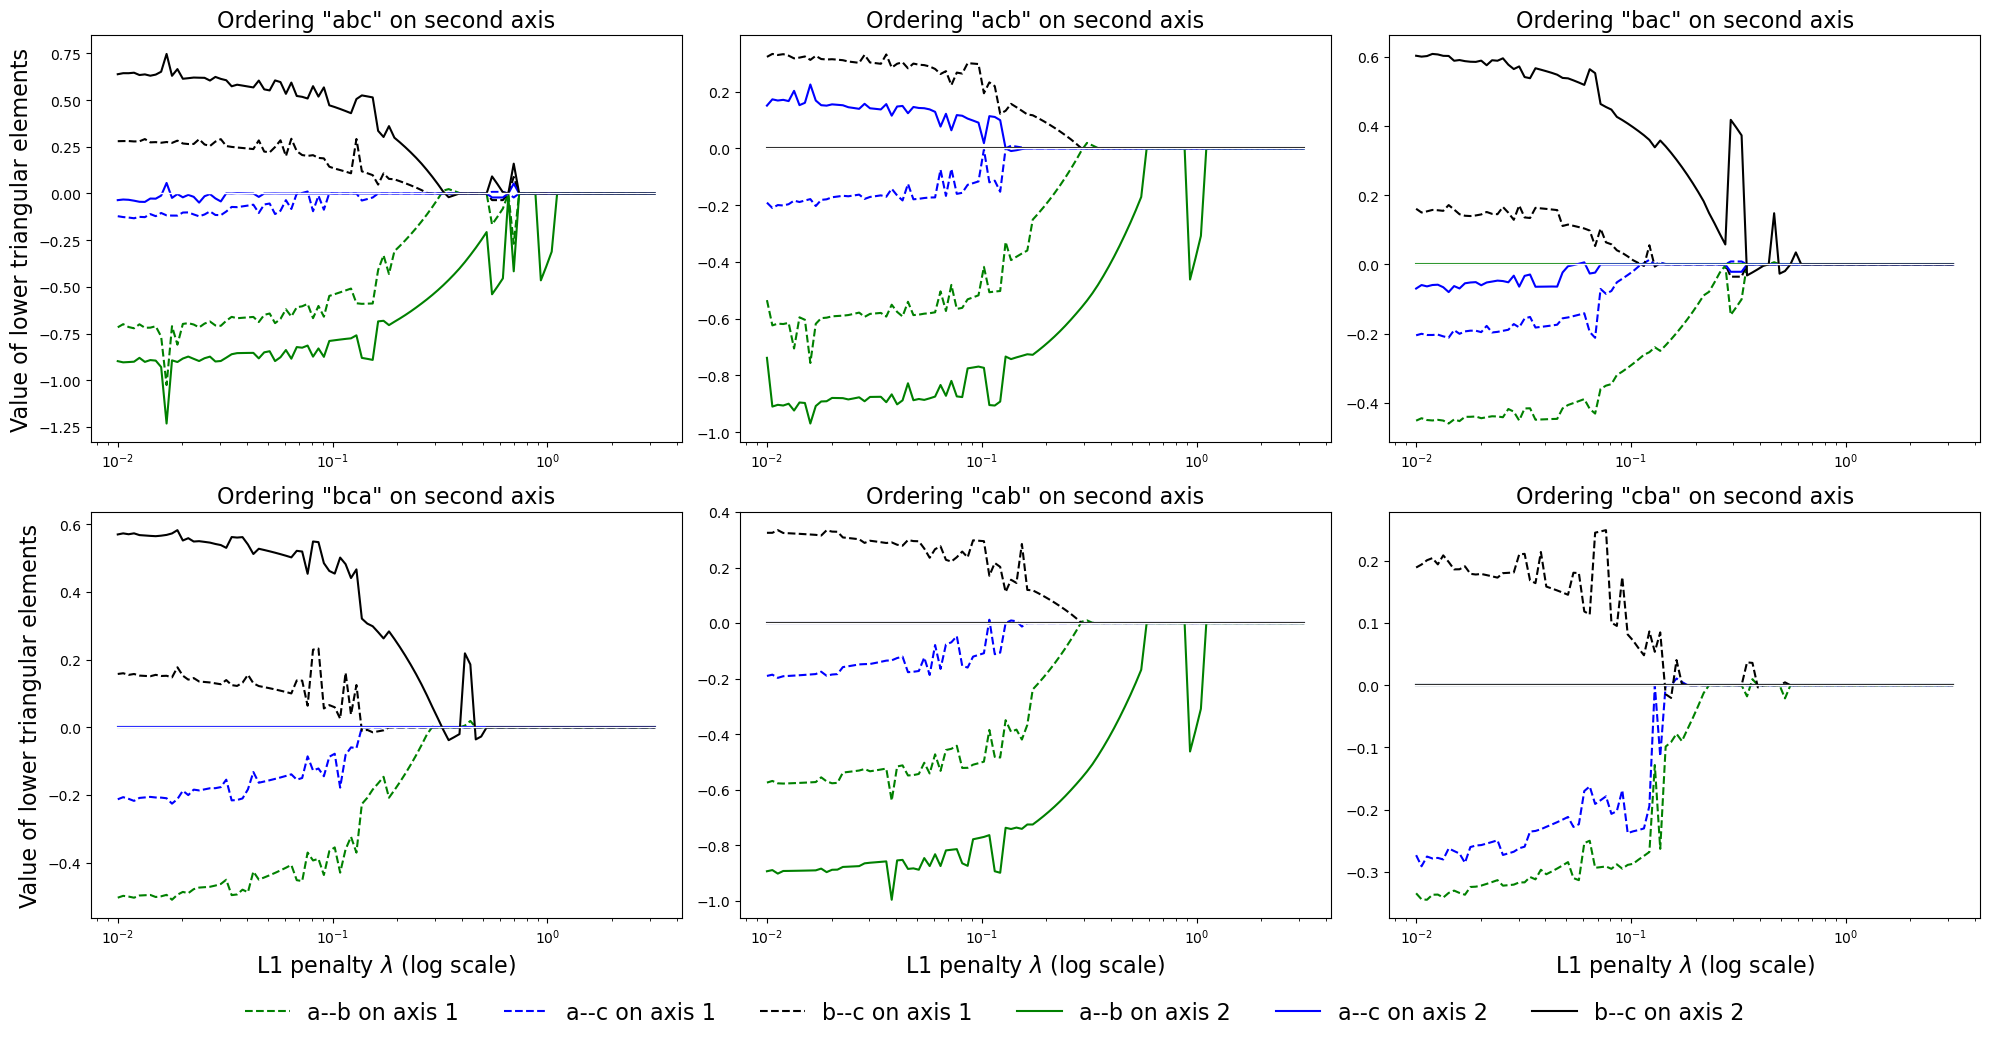

In [151]:


fig, axs = plt.subplots(figsize=(20, 10), ncols=3, nrows=2)
axs = axs.flatten()

for idx, (name, ax) in enumerate(zip(all_patterns.keys(), axs)):
    for idx2, (label, values) in enumerate(all_patterns[name].items()):
        linestyle = '-' if idx2 > 2 else '--'
        color = ['green', 'blue', 'black'][idx2 % 3]
        ax.plot(glassoregs, values, label=label, linestyle=linestyle, color=color)

    ax.set_xscale('log')

    if idx > 2:
        # only draw x axis on bottom row
        ax.set_xlabel(r'L1 penalty $\lambda$ (log scale)', fontsize=16)
    if idx % 3 == 0:
        # only draw y axis on first column
        ax.set_ylabel('Value of lower triangular elements', fontsize=16)
    ax.set_title(f'Ordering "{name}" on second axis', fontsize=16)
    ax.axhline(0, color='white', linewidth=1)

# Get one legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=16, bbox_to_anchor=(0.5, -0.05), frameon=False)
fig.tight_layout()

In [199]:
np.random.seed(0)
dims = (10, 10, 3)
sparsity = 1
true_Ls, _ = generate_Ls(dims, sparsity=sparsity)
true_Ls[-1][1, 0] = 0 # make a->b be zero
X = generate_sylvester_data(true_Ls, normalize=True, source_distribution=np.random.normal)

orderings = {
    "abc": [0, 1, 2],
    "acb": [0, 2, 1],
    "bac": [1, 0, 2],
    "bca": [1, 2, 0],
    "cab": [2, 0, 1],
    "cba": [2, 1, 0]
}

all_patterns = dict()

for name, ordering in orderings.items():
    inverse_ordering = np.argsort(ordering)

    # Re-order the features in X according to the specified ordering
    _X = X[..., ordering].copy()


    patterns_2 = []

    L_init = [np.eye(d) for d in dims]

    frobreg = 0.1
    glassoregs = np.logspace(-1, 1, 10)

    for glassoreg in glassoregs:
        objective, gradient, proximal = get_optimizer_oracles(_X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, (_, eps, _, _) = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=L_init,
            mu=0.2,
            init_alpha=1,
            tau=0.5,
            beta=0.0001,
            max_iter=100,
            tol=1e-5
        )

        # Recover the original features axis
        indices = np.tril_indices_from(Ls[-1], k=-1)
        #Ls[-1] = Ls[-1][inverse_ordering][:, inverse_ordering]
        indices = (
            indices[0][inverse_ordering],
            indices[1][inverse_ordering]
        )
        patterns_2.append(Ls[-1][indices])

    all_values = {
        r"a$\leftrightarrow$b on last axis": [p[0] for p in patterns_2],
        r"a$\leftrightarrow$c on last axis": [p[1] for p in patterns_2],
        r"b$\leftrightarrow$c on last axis": [p[2] for p in patterns_2],
    }

    all_patterns[name] = all_values


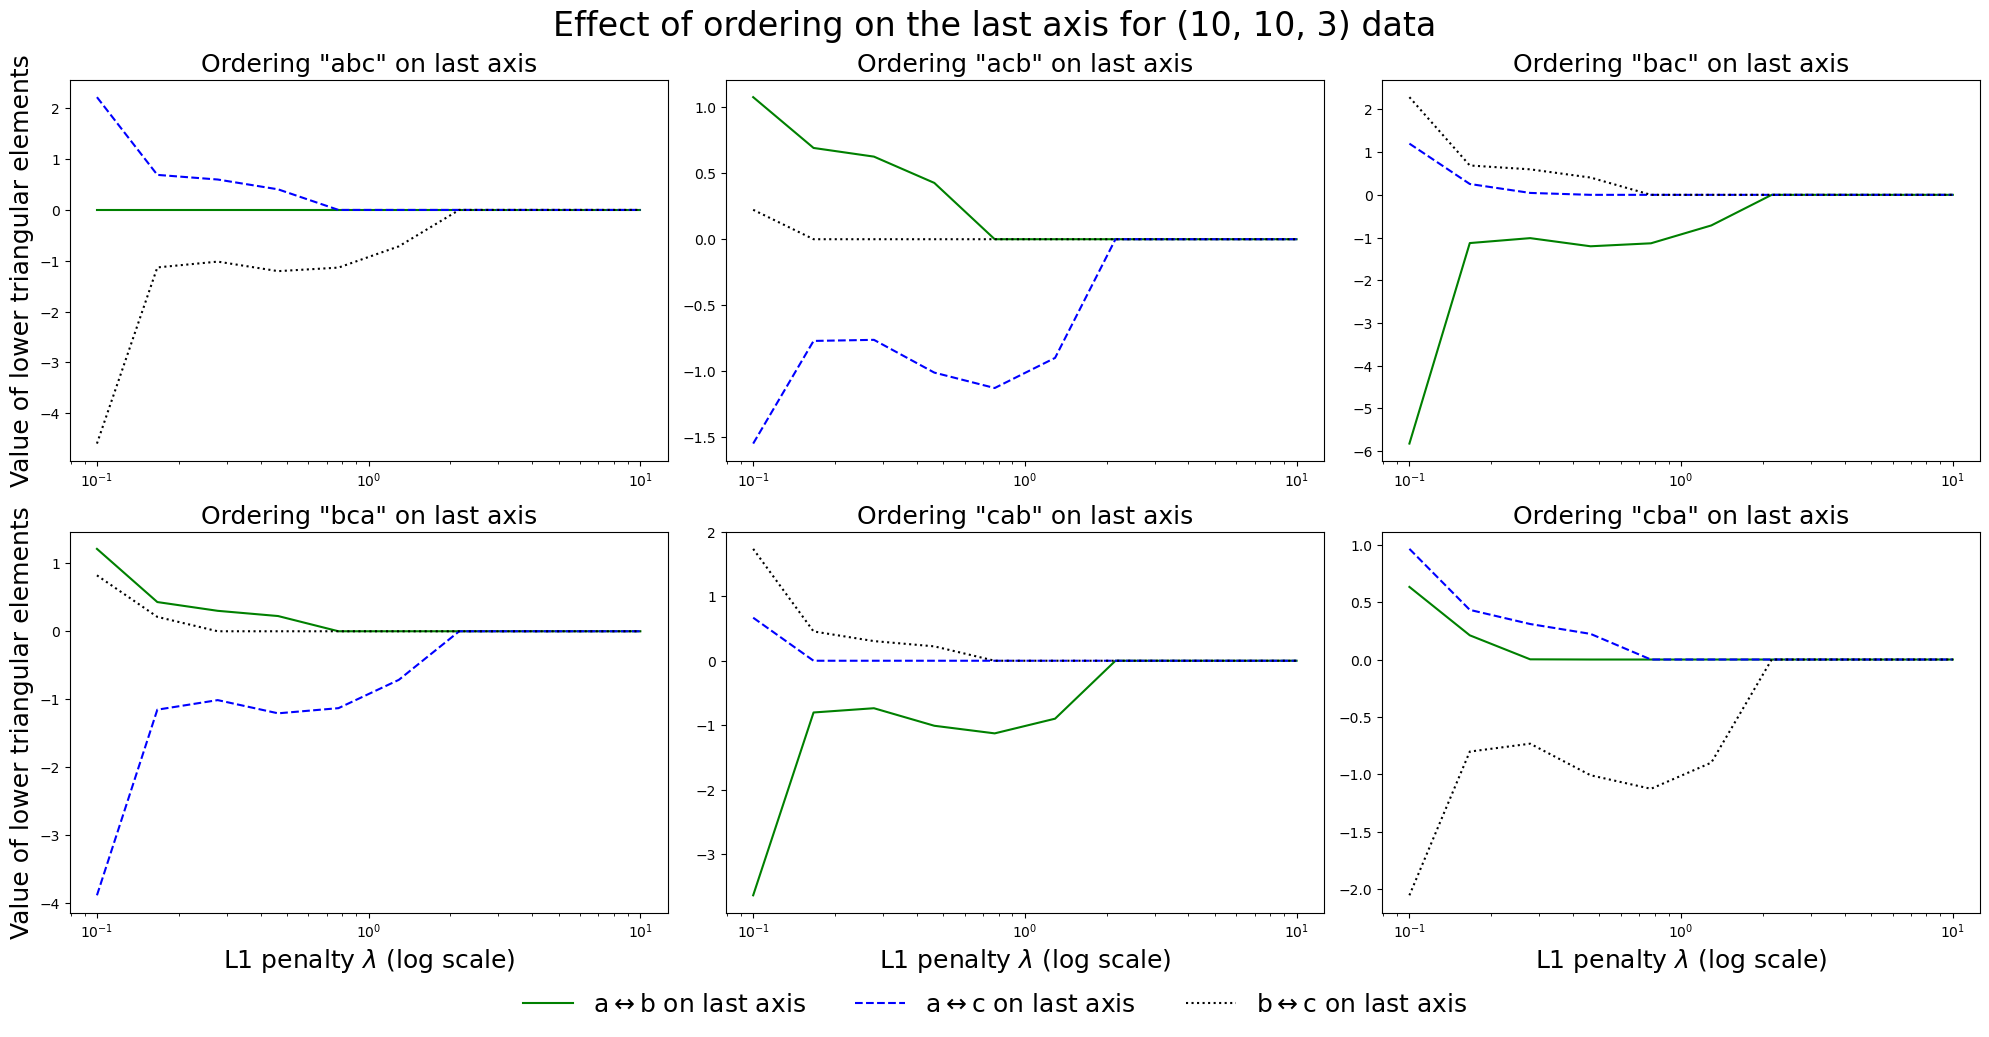

In [200]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=3, nrows=2)
axs = axs.flatten()

for idx, (name, ax) in enumerate(zip(all_patterns.keys(), axs)):
    for idx2, (label, values) in enumerate(all_patterns[name].items()):
        color = ['green', 'blue', 'black'][idx2]
        linestyle = ['-', '--', ':'][idx2]
        ax.plot(glassoregs, values, label=label, linestyle=linestyle, color=color)

    ax.set_xscale('log')

    if idx > 2:
        # only draw x axis on bottom row
        ax.set_xlabel(r'L1 penalty $\lambda$ (log scale)', fontsize=18)
    if idx % 3 == 0:
        # only draw y axis on first column
        ax.set_ylabel('Value of lower triangular elements', fontsize=18)
    ax.set_title(f'Ordering "{name}" on last axis', fontsize=18)
    #ax.axhline(0, color='white', linewidth=1)

# Get one legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=18, bbox_to_anchor=(0.5, -0.05), frameon=False)
fig.suptitle('Effect of ordering on the last axis for (10, 10, 3) data', fontsize=24)
fig.tight_layout()

In [201]:
fig.savefig("figures/effect_of_ordering.pdf", bbox_inches='tight')

## Full table test

### Reverse Ordering

In [223]:
np.random.seed(0)
dims = (100, 50)
sparsity = 0.1
Ls, L_patterns = generate_Ls(dims, sparsity=sparsity)
Ls[1] = (
    np.diag(np.ones(dims[1]))
    + np.diag(np.ones(dims[1]-1), k=-1)
)

ordering = np.arange(dims[1])[::-1]
inverse_ordering = np.argsort(ordering)

L_patterns[1] = Ls[1] != 0
X = generate_sylvester_data(Ls, normalize=True)
X = X[:, ordering]

L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoregs = np.logspace(0.9, -2, 100) # (50, 50)
print("Starting CLGAM")
Lss, _ = warm_start(X, L_init, glassoregs=glassoregs, dont_warm_start=True, verbose=True, max_iter=1000)
print("Starting LGAM on 50-axis")
Lss_lgam, _ = warm_start(X, L_init, glassoregs=glassoregs, sample_axes={0}, dont_warm_start=True, max_iter=1000)

# Recoover the original ordering
Lss = [[L[0], np.tril((L[1] + L[1].T)[inverse_ordering][:, inverse_ordering], k=-1)] for L in Lss]
Lss_lgam = [[L[0], np.tril((L[1] + L[1].T)[inverse_ordering][:, inverse_ordering], k=-1)] for L in Lss_lgam]

Starting CLGAM
L1 Param: 7.943282347242816
L1 Param: 7.4251814446093825
L1 Param: 6.940873693670064
L1 Param: 6.488154934780253
L1 Param: 6.064964774694602
L1 Param: 5.669377209398
L1 Param: 5.299591858562764
L1 Param: 4.9539257717386915
L1 Param: 4.630805768984698
L1 Param: 4.328761281083059
L1 Param: 4.04641765675095
L1 Param: 3.7824899063893853
L1 Param: 3.535776853896366
L1 Param: 3.305155669928257
L1 Param: 3.0895767617294028
L1 Param: 2.888058996272796
L1 Param: 2.699685234971597
L1 Param: 2.5235981596392634
L1 Param: 2.3589963707015946
L1 Param: 2.205130739903046
L1 Param: 2.061301000907923
L1 Param: 1.9268525622797414
L1 Param: 1.8011735283341335
L1 Param: 1.6836919143067435
L1 Param: 1.5738730431619037
L1 Param: 1.4712171121945685
L1 Param: 1.3752569183507302
L1 Param: 1.2855557319139026
L1 Param: 1.2017053088804863
L1 Param: 1.1233240329780276
L1 Param: 1.0500551788704104
L1 Param: 0.9815652886455575
L1 Param: 0.9175426541967856
L1 Param: 0.8576958985908943
L1 Param: 0.801752

/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:79: RuntimeWarning: invalid value encountered in divide
  precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(dims))]
/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:80: RuntimeWarning: invalid value encountered in divide
  shared_precs = shared_TPs / (shared_TPs + shared_FPs)
/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:86: RuntimeWarning: invalid value encountered in divide
  (TPs[i]*TNs[i] - FPs[i]*FNs[i])
/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:97: RuntimeWarning: invalid value encountered in divide
  (shared_TPs * shared_TNs - shared_FPs * shared_FNs)


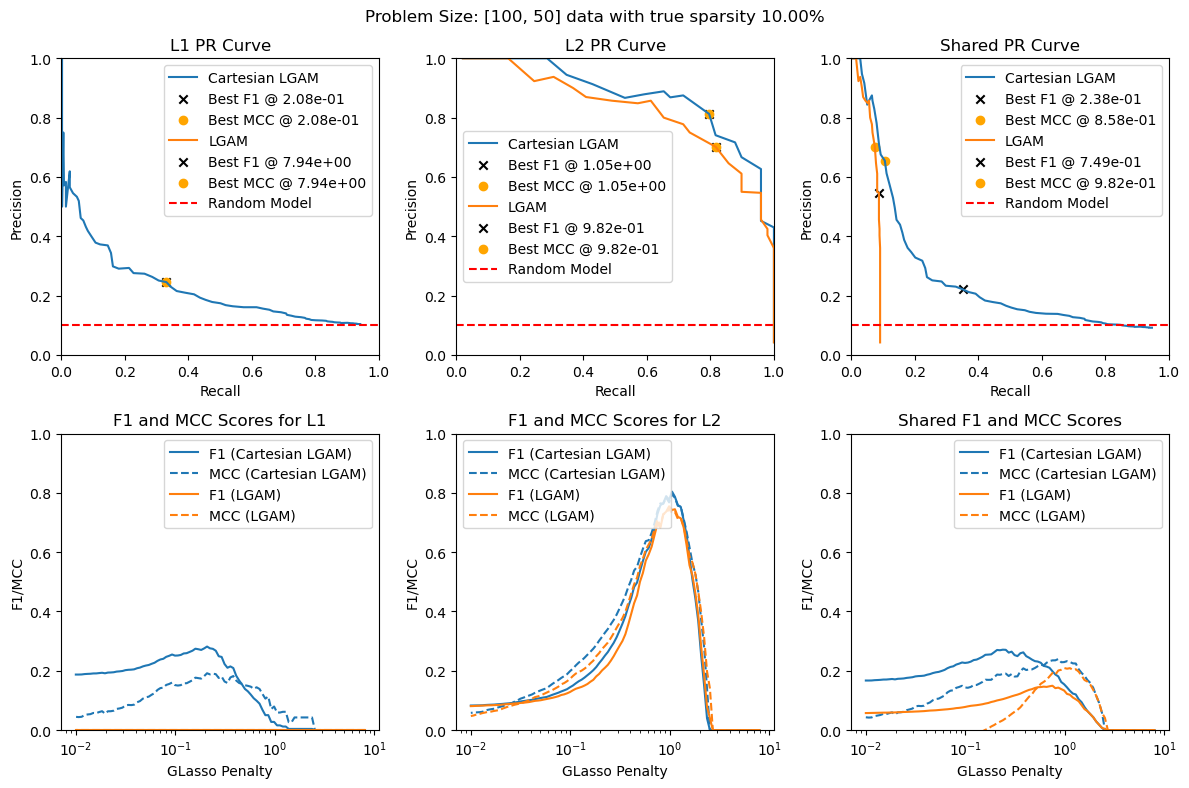

In [224]:
L_estim_patterns = patternify_Ls(Lss)
L_lgam_estim_patterns = patternify_Ls(Lss_lgam)

one_example_prs(
    L_patterns=L_patterns,
    Lss=Lss,
    Lss_lgam=Lss_lgam,
    glassoregs=glassoregs,
    sparsity=sparsity
)
pass

In [225]:
estim_edges = [L[1][np.tril_indices_from(L[1], k=-1)] for L in L_estim_patterns]
baseline_edges = [L[1][np.tril_indices_from(L[1], k=-1)] for L in L_lgam_estim_patterns]
true_edges = L_patterns[1][np.tril_indices_from(L_patterns[1], k=-1)]

precs_clgam = [1] + [precision_score(true_edges, e) for e in estim_edges] + [0]
precs_lgam = [1] + [precision_score(true_edges, e) for e in baseline_edges] + [0]
recs_clgam = [0] + [recall_score(true_edges, e) for e in estim_edges] + [1]
recs_lgam = [0] + [recall_score(true_edges, e) for e in baseline_edges] + [1]

mccs_clgam = [matthews_corrcoef(true_edges, e) for e in estim_edges]
mccs_lgam = [matthews_corrcoef(true_edges, e) for e in baseline_edges]

sort_idxs = np.argsort(recs_clgam)
auc_clgam = auc(np.array(recs_clgam)[sort_idxs], np.array(precs_clgam)[sort_idxs])
sort_idxs = np.argsort(recs_lgam)
auc_lgam = auc(np.array(recs_lgam)[sort_idxs], np.array(precs_lgam)[sort_idxs])

print(
    f"""
    CLGAM:
        Max MCC: {max(mccs_clgam)}
        AUCPR: {auc_clgam}
    LGAM:
        Max MCC: {max(mccs_lgam)}
        AUCPR: {auc_lgam}
    """
)

/Users/baileyandrew/mambaforge/envs/Cartesian-LGAM/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/baileyandrew/mambaforge/envs/Cartesian-LGAM/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/baileyandrew/mambaforge/envs/Cartesian-LGAM/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif


    CLGAM:
        Max MCC: 0.7960956725677218
        AUCPR: 0.8560161080536466
    LGAM:
        Max MCC: 0.7460144207867497
        AUCPR: 0.8136945934874568
    


In [227]:
with open("results/synthetic_lopsided_ar1_reverse", "wb") as fp:
    pickle.dump({
        'CLGAM': L_estim_patterns,
        'LGAM': L_lgam_estim_patterns,
        'True': L_patterns,
        'ordeering': ordering
    }, fp)

In [230]:
np.random.seed(0)
dims = (100, 50)
sparsity = 0.1
Ls, L_patterns = generate_Ls(dims, sparsity=sparsity)
Ls[1] = (
    np.diag(np.ones(dims[1]))
    + np.diag(np.ones(dims[1]-1), k=-1)
)

L_patterns[1] = Ls[1] != 0
X = generate_sylvester_data(Ls, normalize=True)

shuffled = 10
ordering = np.concatenate([
    np.random.choice(np.arange(shuffled), size=shuffled, replace=False),
    np.arange(shuffled, 50)
])
inverse_ordering = np.argsort(ordering)

X = X[:, ordering]

L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoregs = np.logspace(0.9, -2, 10) # (50, 50)
print("Starting CLGAM")
Lss, _ = warm_start(X, L_init, glassoregs=glassoregs, dont_warm_start=True, verbose=True, max_iter=1000)
print("Starting LGAM on 50-axis")
Lss_lgam, _ = warm_start(X, L_init, glassoregs=glassoregs, sample_axes={0}, dont_warm_start=True, max_iter=1000)

# Recoover the original ordering
Lss = [[L[0], np.tril((L[1] + L[1].T)[inverse_ordering][:, inverse_ordering], k=-1)] for L in Lss]
Lss_lgam = [[L[0], np.tril((L[1] + L[1].T)[inverse_ordering][:, inverse_ordering], k=-1)] for L in Lss_lgam]

Starting CLGAM
L1 Param: 7.943282347242816
L1 Param: 3.7824899063893853
L1 Param: 1.8011735283341335


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: 0.8576958985908943
L1 Param: 0.4084238652674523
L1 Param: 0.1944862438937363
L1 Param: 0.09261187281287937
L1 Param: 0.04410059454176737
L1 Param: 0.021000141557086564
L1 Param: 0.01
Starting LGAM on 50-axis


/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:79: RuntimeWarning: invalid value encountered in divide
  precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(dims))]
/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:80: RuntimeWarning: invalid value encountered in divide
  shared_precs = shared_TPs / (shared_TPs + shared_FPs)
/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:86: RuntimeWarning: invalid value encountered in divide
  (TPs[i]*TNs[i] - FPs[i]*FNs[i])
/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:97: RuntimeWarning: invalid value encountered in divide
  (shared_TPs * shared_TNs - shared_FPs * shared_FNs)


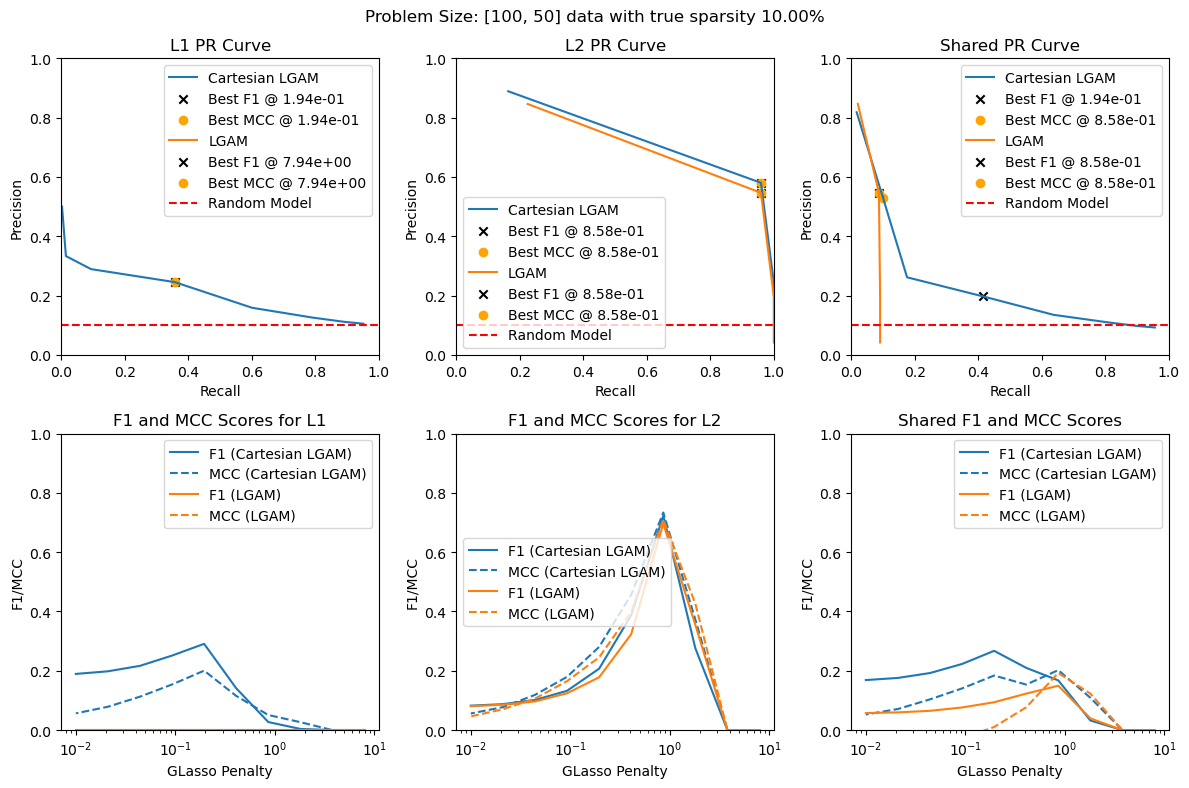

In [ ]:
L_estim_patterns = patternify_Ls(Lss)
L_lgam_estim_patterns = patternify_Ls(Lss_lgam)

one_example_prs(
    L_patterns=L_patterns,
    Lss=Lss,
    Lss_lgam=Lss_lgam,
    glassoregs=glassoregs,
    sparsity=sparsity
)
pass

In [ ]:
with open("results/synthetic_lopsided_ar1_20_shuffled", "wb") as fp:
    pickle.dump({
        'CLGAM': L_estim_patterns,
        'LGAM': L_lgam_estim_patterns,
        'True': L_patterns,
        'ordeering': ordering
    }, fp)